<a href="https://colab.research.google.com/github/tommysisk/CHEM-40/blob/main/sodium_lab_CHEM76.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##define imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
from IPython.display import display, Latex
from IPython.display import Audio
import IPython
import os
from itertools import repeat
import warnings
warnings.filterwarnings('ignore')


In [ ]:
def make_symbols():
    unicharacters = ["\u03B1",
                        "\u03B2",
                        "\u03B3",
                        "\u03B4",
                        "\u03B5",
                        "\u03B6",
                        "\u03B7",
                        "\u03B8",
                        "\u03B9",
                        "\u03BA",
                        "\u03BB",
                        "\u03BC",
                        "\u03BD",
                        "\u03BE",
                        "\u03BF",
                        "\u03C0",
                        "\u03C1",
                        "\u03C2",
                        "\u03C3",
                        "\u03C4",
                        "\u03C5",
                        "\u03C6",
                        "\u03C7",
                        "\u03C8",
                        "\u03C9",
                        "\u00C5"]
    keys = "alpha,beta,gamma,delta,epsilon,zeta,eta,theta,iota,kappa,lambda,mu,nu,xi,omicron,pi,rho,final_sigma,sigma,tau,upsilon,phi,chi,psi,omega,angstrom"
    return dict(zip(keys.split(","),unicharacters))
symbols = make_symbols()

In [ ]:
##make a dictionary to store the quantum defect terms
##see the lab handout to understand where this comes from
quantum_defects_P_terms = dict(zip([*range(3,8)],[.883,.867,.862,.859,.858]))

In [ ]:

#load in the csv data from the google drive that's been shared with you
##SHOULD NOT NEED TO CHANGE THIS
url = "https://drive.google.com/file/d/1_SXlAXic4yvN0B9ZdE23QwbLwFJcvbix/view?usp=share_link"
url='https://drive.google.com/uc?id=' + url.split('/')[-2]

dataframe = pd.read_csv(url, names = f"Wavelength ({symbols['angstrom']}),Intensity".split(","))

print("here's what the dataframe contains (this is only the first few rows!)")
display(dataframe.head().style.set_caption("Experimental Data"))

#we can take the contents of the dataframe and put it into a numpy array, the contents remain the same!
data = dataframe.to_numpy()

here's what the dataframe contains (this is only the first few rows!)


,Wavelength (Å),Intensity
0,3000.139972,0.005798
1,3000.379924,0.013123
2,3000.639872,0.006409
3,3000.879824,0.008850
4,3001.139772,0.006714


  # plot the experimental data

Text(0.5, 1.0, 'Experimental Data - Intensity vs. Wavelength (Å)')

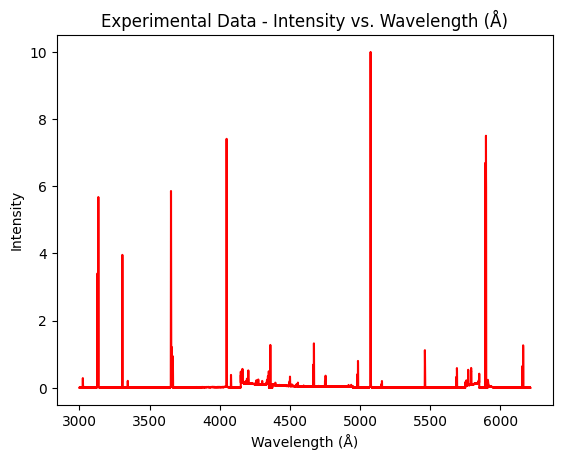

In [ ]:
plt.plot(*data.T, color = "red")
plt.ylabel("Intensity")
plt.xlabel(f"Wavelength ({symbols['angstrom']})")
plt.title(f"Experimental Data - Intensity vs. Wavelength ({symbols['angstrom']})")

 # we can also plot the experimental data over sub-intervals of the range of wavelengths

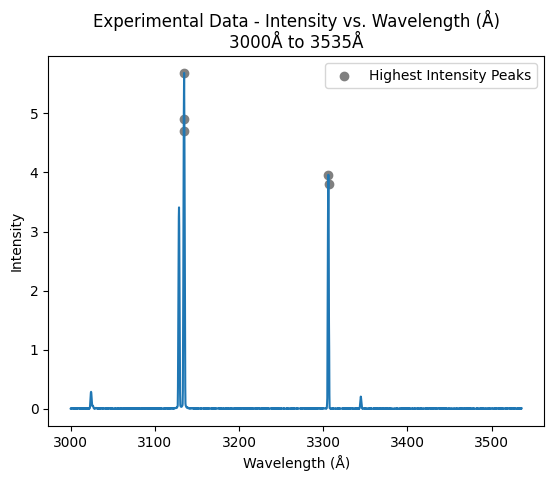

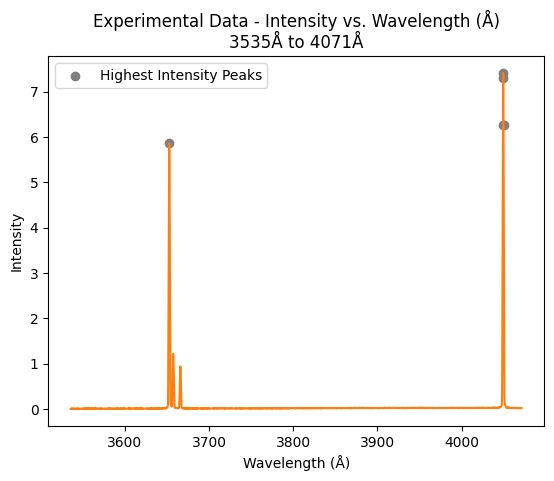

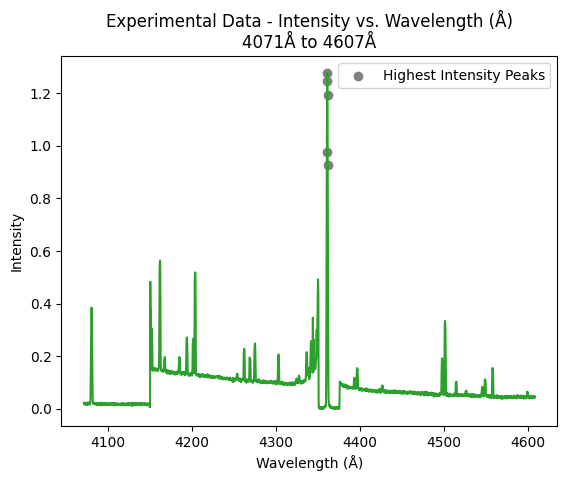

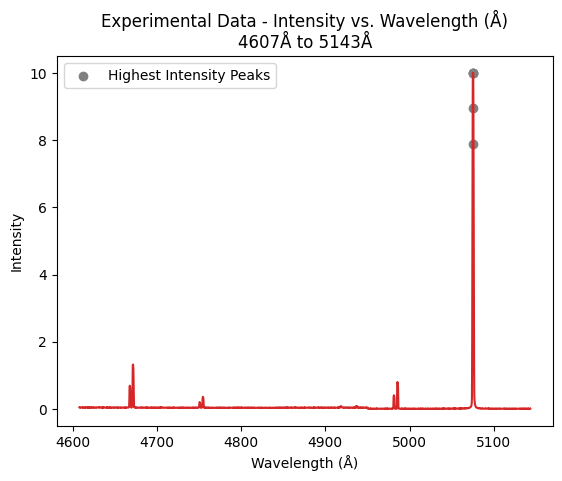

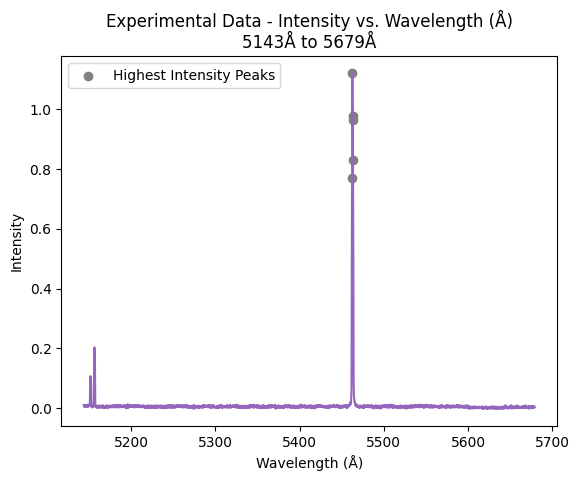

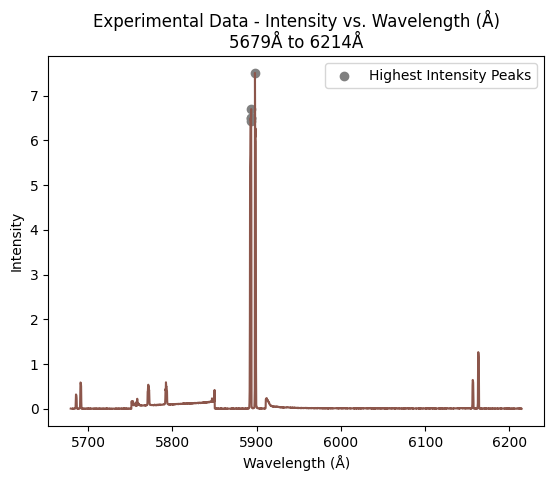

In [ ]:
most_intense_segments = []
segments = []
most_intense_indices = []
for i,segment in enumerate(np.array_split(data,6)):
    segments.append(segment)
    plt.figure()
    idx_ = segment[:,1].argsort()[::-1];most_intense_indices.append(idx_)
    most_intense_ = segment[idx_[:5]];most_intense_segments.append(most_intense_)
    plt.plot(*segment.T, color = f"C{i}")
    plt.ylabel("Intensity")
    plt.xlabel(f"Wavelength ({symbols['angstrom']})")
    plt.title((f"Experimental Data - Intensity vs. Wavelength ({symbols['angstrom']})\n"
              f"{int(segment[:,0].min())}{symbols['angstrom']} to {int(segment[:,0].max())}{symbols['angstrom']}"))
    plt.scatter(*most_intense_.T, color = "gray", label = "Highest Intensity Peaks") #scatter plot of mots intense points
    plt.legend()


 # alternatively, we can simply pull out the 30 most intense wavelenghts from the entire dataset at once, automatically

 # here, the most intense wavelengths are shown as a scatter plot atop the data in grey

,Wavelength (Å),Intensity
0,5075.664867,10.000000
1,5075.164967,10.000000
2,5075.424915,10.000000
3,5075.924815,8.957520
4,5074.925015,7.883911
5,5897.980404,7.505493
6,4049.130174,7.413635
7,4049.370126,7.306519
8,5893.441312,6.697693
9,5892.681464,6.497498


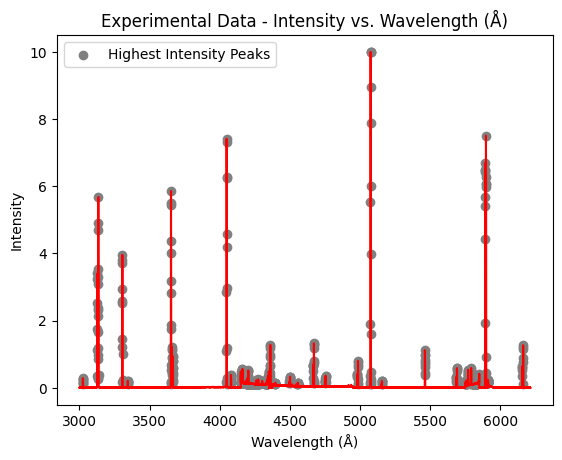

In [ ]:
#sort by the intensity column and display the first 30 values
sorted_by_intensity = dataframe.sort_values(dataframe.columns[-1], ascending = False).reset_index(drop = True)
display(sorted_by_intensity[:30].style.set_caption("Most Intense Wavelength (in order of intensity)"))

#plot the entire dataset as a reference
plt.plot(*data.T, color = "red")
plt.ylabel("Intensity")
plt.xlabel(f"Wavelength ({symbols['angstrom']})")
plt.title(f"Experimental Data - Intensity vs. Wavelength ({symbols['angstrom']})")


#scatter the 30 most intense wavelengths on top of the data
plt.scatter(*sorted_by_intensity[:1000].to_numpy().T, color = "gray", label = "Highest Intensity Peaks") #scatter plot of mots intense points
plt.legend()

 # We'll need to do a linear regression. I've defined a function to do this below

In [ ]:
def PolyRegression1D(x, y, degree = 1, intercept = True):
    """one dimensional (y is a single variable function of x) fitting using an n-degree polynomial

    RETURNS: a dictionary
    KEY  , VALUE

    ypred , estimated y values based on regression result (np.ndarray)
    co-effs , co-efficients for each degree of the polynomial in increasing order (np.ndarray)
    r2 , the r-squared value from the fit (float)
    y_residuals , difference between actual y data and the predicted y data

    ADDITIONAL RETURNS FOR DEGREE == 1 (fitting a line)

    slope_error , uncertainty in the predicted slope
    int_error , uncertainty in the predicted y-intercept

    """
    X = []
    if intercept:
        start = 0
    else:
        start = 1
    for i in range(start,degree+1):
        X.append(x**i)
    X = np.stack(X, axis = 1) #make matrix to solve co-efficients of
    b = np.linalg.inv(X.T@X)@X.T@y #solve for co-efficients
    yhat = X@b.reshape(-1,1) #predict y-values based on co-efficients
    yres = y-yhat #get y residuals
    yres2 = yres**2 #get squared residuals
    yvar = (y-y.mean())**2 #get un-normalized variance of y
    r2 = 1 - (yres2.sum()/yvar.sum()) #compute r-squared
    if degree == 1:
        """compute error of slope and intercept if applicable"""
        x2 = x**2
        slope_error = np.sqrt(np.sum(yres2)/((len(x)-2)*np.sum((x-x.mean())**2)))
        int_error = np.sqrt((np.sum(yres2)*x2.sum())/((len(x)-2)*len(x)*np.sum((x-x.mean())**2)))

        dic = dict(zip("ypred,co-effs,r2,y_residuals,slope_error,int_error".split(","),
                        [yhat,b,r2,yres,slope_error,int_error]))
        fitter = fit_new_data(b)
        return dic,fitter

    else:
        return dict(zip("ypred,co-effs,r2,y_residuals".split(","),[yhat, b, r2, yres]))


class fit_new_data:

    def __init__(self,coeffs):
        self.coeffs = coeffs

    def __call__(self,data):
        fit_data = np.stack([np.ones(len(data)),data],axis = 1)
        return fit_data@self.coeffs.reshape(-1,1)



 # We need to make 2 Corrections to our raw data

 # 1) use the Hg standard to correct the observed wavelengths to the true wavelengths. We do this by using the largest peaks from the observed Hg data and doing a linear regression with the same peaks with their true wavelengths. We will then use the linear regression co-efficients to correct all of the sodium data

 # 2) we need to adjust the wavelengths to what they would have been if we had carried out the experiment in a vaccum

 # Peak lables of expected observed wavelengths are given below

 # Important point here is "expected". We are unlikely to see exactly these wavelengths which means that we need to find the wavelength observed in our data that is closest to the expected wavelengths

In [ ]:
hg_expected_peaks = np.array([3129.22,3135.27,3653.1,4049.5,4360.9,5464.1,5771.1,5792.3]).round(3)

na_expected_peaks = np.array([3306.3,4393,4396.5,4426.4,4497,4500.6,4544.9,4548.3,4667.9,4671.7,4750.9,4754.7,
                    4981.6,4985.8,5151.4,5156.1,5684.8,5690.3,5892.4,5898.3,6156.5,6163.1]).round(3)

impure_expected_peaks = np.array([3657.9,3666.2,4162.2,4167.5,4185.3,4194.4,4201.5,4204.1,4262.5,4269.3,4275.2,4303.4,
                         4336.6,4349.9,4513.8,4525.7,4557.5,5075.9]).round(3)

total_expected_peaks = np.sum(np.array([len(i) for i in
                       [hg_expected_peaks,na_expected_peaks,impure_expected_peaks]]))

print(f"Total number of peaks we're interested in is : \
{total_expected_peaks}")



Total number of peaks we're interested in is : 48


 # we know we're looking for 48 datapoints based on the expected wavelengths

 # the find_expected_oberved function defined below will find the observed datapoints closest to the expected datapoints

 # However, we have to be careful as we essenitally have every single wavelength in the interval from 3000-6200

 # We only want to consider peaks with non-trivial intensities

 # the first variable assigned in the cell below is called n_most_intense
 # and is there for you to change the number of the N most intense peaks to consider when finding the peaks in our observed data that are closest to the actual data

In [ ]:
n_most_intense = 1000


## the below functions use the data variable as a global variable to change it within the function
def find_closest(value:"value to find the closest to"):
    """returns the index of the closest data point in data and the value from data itself
    will also remove the selected datapoint from the data"""
    global data
    idx = abs(value-data[:,0]).argmin()
    val = data[idx]
    data = np.delete(data,idx,axis = 0)
    return val

def find_expected_observed(expected_peaks):
    global data
    peaks_data = np.concatenate([expected_peaks.reshape(-1,1),
                    np.stack(list(map(find_closest,expected_peaks)))],axis = 1)

    peaks_dataframe = pd.DataFrame(data = peaks_data,
                        columns = "Expected,Observed,Intensity".split(","))
    return peaks_dataframe


try:
  del data
except:
  pass

data = dataframe.to_numpy()
idx = data[:,1].argsort()[::-1]
data = data[idx[:n_most_intense]]

#for Hg
hg_peaks_dataframe = find_expected_observed(hg_expected_peaks)
display(hg_peaks_dataframe.style.set_caption("Hg peak Data"))
print("\n")

#for impure
impure_peaks_dataframe = find_expected_observed(impure_expected_peaks)
display(impure_peaks_dataframe.style.set_caption("Impure Peak Data"))

#for Na
print("\n")
na_peaks_dataframe = find_expected_observed(na_expected_peaks)
display(na_peaks_dataframe.style.set_caption("Na Peak Data"))

del data
data = dataframe.to_numpy()



,Expected,Observed,Intensity
0,3129.220000,3129.254149,2.318726
1,3135.270000,3135.152969,4.705200
2,3653.100000,3653.229354,4.367981
3,4049.500000,4049.370126,7.306519
4,4360.900000,4360.887822,1.277161
5,5464.100000,5463.827235,0.428467
6,5771.100000,5771.125775,0.495911
7,5792.300000,5792.341532,0.592041


,Expected,Observed,Intensity
0,3657.900000,3658.008398,0.876160
1,3666.200000,3666.086783,0.912476
2,4162.200000,4162.247550,0.538025
3,4167.500000,4167.546491,0.189819
4,4185.300000,4185.202959,0.195923
5,4194.400000,4194.281144,0.253296
6,4201.500000,4201.579684,0.267029
7,4204.100000,4204.099180,0.497437
8,4262.500000,4262.587483,0.200806
9,4269.300000,4269.386123,0.187988


,Expected,Observed,Intensity
0,3306.300000,3306.278744,3.795471
1,4393.000000,4392.961408,0.118408
2,4396.500000,4396.480704,0.147705
3,4426.400000,4396.980604,0.143433
4,4497.000000,4496.840632,0.138855
5,4500.600000,4500.619876,0.322876
6,4544.900000,4548.930214,0.108948
7,4548.300000,4557.148570,0.146790
8,4667.900000,4667.906419,0.670471
9,4671.700000,4671.705659,1.277466


In [ ]:
#not in vacuum
Hg_lambda_true = np.array([5790.66 ,
5769.60 ,
5460.74 ,
4358.33 ,
4046.56 ,
3650.15 ,
3131.55 ,
3125.67])[::-1]
print(Hg_lambda_true)


[3125.67 3131.55 3650.15 4046.56 4358.33 5460.74 5769.6  5790.66]


In [ ]:
display(hg_peaks_dataframe.style.set_caption("Hg peak Data"))

,Expected,Observed,Intensity
0,3129.220000,3129.254149,2.318726
1,3135.270000,3135.152969,4.705200
2,3653.100000,3653.229354,4.367981
3,4049.500000,4049.370126,7.306519
4,4360.900000,4360.887822,1.277161
5,5464.100000,5463.827235,0.428467
6,5771.100000,5771.125775,0.495911
7,5792.300000,5792.341532,0.592041


In [ ]:
# here, I show how to pull our observed wavelengths out of the dataframe printed above
Hg_lambda_observed = hg_peaks_dataframe["Observed"].to_numpy()
# we'll also pull the observed wavelengths for Na
Na_lambda_observed = na_peaks_dataframe["Observed"].to_numpy()

Text(0.5, 1.0, 'Experimental Data - True vs. Observed (Å)')

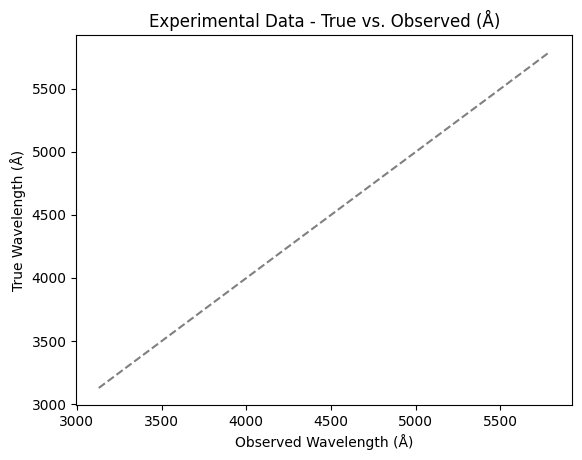

In [ ]:
plt.plot(Hg_lambda_observed,Hg_lambda_true, label = "Raw Data", c = "grey", ls = "--")
plt.ylabel(f"True Wavelength ({symbols['angstrom']})")
plt.xlabel(f"Observed Wavelength ({symbols['angstrom']})")
plt.title(f"Experimental Data - True vs. Observed ({symbols['angstrom']})")

 # Now we will see an example of how to fit data, we will fit Hg obs vs. Hg true


 # the fitter object that is returned here allows us to fit new data using the same co-efficients,
 # I will show how to use this on the observed Na data a few cells later

In [ ]:
fit_result_Hg, fitter = PolyRegression1D(x = Hg_lambda_observed, y = Hg_lambda_true)


 # let's see what's in the fit result

 # the fit result is a python dictionary!
 # you can access items in the dictionary by simply doing something like
 # fit_result["one of the keys in the dictionary"]


In [ ]:
fit_result_Hg["co-effs"]

array([-5.34180568,  1.00058847])

 # Here's how to get the fitted data

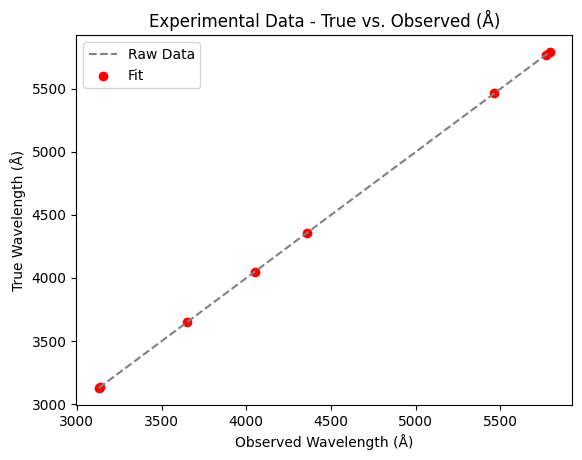

In [ ]:
Hg_fitted_data = fit_result_Hg["ypred"] #ypred is one of the keys in the dictionary

#let's plot the result

plt.plot(Hg_lambda_observed,Hg_lambda_true, label = "Raw Data", c = "grey", ls = "--")
plt.ylabel(f"True Wavelength ({symbols['angstrom']})")
plt.xlabel(f"Observed Wavelength ({symbols['angstrom']})")
plt.title(f"Experimental Data - True vs. Observed ({symbols['angstrom']})")
plt.scatter(Hg_lambda_observed,Hg_fitted_data, label = "Fit", c = "red")
plt.legend()


 # the variable named "fitter" can be used to fit new data using the result from an old fit, I show how to do this below
 # recall that the fitter variable was returned by the function Polyregression1D when it was used a few cells back

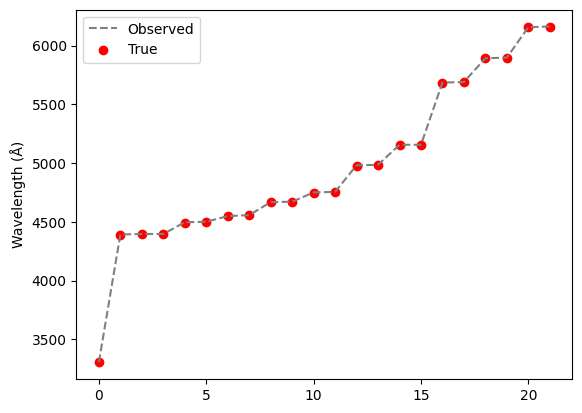

In [ ]:
Na_lambda_true = fitter(Na_lambda_observed) #fit observed Na data to get true Na data (in terms of wavelength in angstroms)
plt.plot(Na_lambda_observed, color = "grey", ls = "--", label = "Observed")
plt.scatter(np.arange(len(Na_lambda_observed)),Na_lambda_true, color = "red", label = "True")
plt.ylabel(f"Wavelength ({symbols['angstrom']})")
plt.legend()

 # Now let's convert our true Na data to vacuum wavelength

In [ ]:
def vacuum_wavelength(x):
    return x*1.00026343 + 0.07621

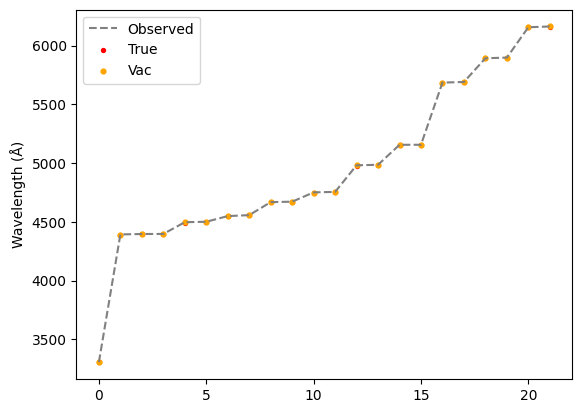

In [ ]:
Na_lambda_vac = vacuum_wavelength(Na_lambda_true)

plt.plot(Na_lambda_observed, color = "grey", ls = "--", label = "Observed")
plt.scatter(np.arange(len(Na_lambda_observed)),Na_lambda_true, color = "red", label = "True",s = 8)

plt.scatter(np.arange(len(Na_lambda_observed)),Na_lambda_vac, color = "orange", label = "Vac", s = 12)

plt.ylabel(f"Wavelength ({symbols['angstrom']})")
plt.legend()

 # Now let's convert our true Na wavelength data to wavenumbers in cm-1

In [ ]:
def convert_to_wavenumber(x):
    return 1/(x*1e-8)
Na_wavenumber = convert_to_wavenumber(Na_lambda_vac)

 # let's gather all the calculations we've done for just the sodium data and put it in a dataframe

In [ ]:
previous_data = na_peaks_dataframe.to_numpy()
new_data = np.stack([Na_lambda_true,Na_lambda_vac,Na_wavenumber], axis = 1)[...,0]
all_names = list(na_peaks_dataframe.columns) + "True,Vac,Wavenumber(cm^-1)".split(",")
all_names = [i+f" ({symbols['angstrom']})" if not i in ("Wavenumber(cm^-1)","Intensity")
             else i for i in all_names]
total_data = np.concatenate([previous_data,new_data], axis = 1)
na_dataframe_total = pd.DataFrame(data = total_data, columns = all_names)
reindex = ['Expected (Å)', 'Observed (Å)','True (Å)','Vac (Å)', 'Wavenumber(cm^-1)','Intensity']
na_dataframe_total = na_dataframe_total.reindex(columns = reindex)
display(na_dataframe_total.style.set_caption("Na data summary"))

,Expected (Å),Observed (Å),True (Å),Vac (Å),Wavenumber(cm^-1),Intensity
0,3306.300000,3306.278744,3302.882586,3303.828874,30267.911510,3.795471
1,4393.000000,4392.961408,4390.204730,4391.437452,22771.587002,0.118408
2,4396.500000,4396.480704,4393.726097,4394.959746,22753.336951,0.147705
3,4426.400000,4396.980604,4394.226291,4395.460072,22750.746987,0.143433
4,4497.000000,4496.840632,4494.145084,4495.405187,22244.935850,0.138855
5,4500.600000,4500.619876,4497.926552,4499.187651,22226.234547,0.322876
6,4544.900000,4548.930214,4546.265319,4547.539152,21989.915130,0.108948
7,4548.300000,4557.148570,4554.488512,4555.764510,21950.212697,0.146790
8,4667.900000,4667.906419,4665.311538,4666.616731,21428.800726,0.670471
9,4671.700000,4671.705659,4669.113014,4670.419208,21411.354214,1.277466


In [ ]:
 # now we want to compute the energies between transitions for the different values of n within the L orbital (L quantum number)

 # now we want to compute the theoretical energies between transitions for the different values of n within the L orbital (L quantum number)

 # note that the function has an absolute value option which we use by default to make things simpler down the line




 # Also Note that in accordance with the lab handout, all of the transition "energies" are unitless as we have divided by R. I am still calling them energies as we need a name but they are techincally unitless changes. To convert them back into wavenumber, we can just multiply by R, but we don't need to in any of these cases!

In [ ]:
Rna = 109734.698

def Wn(n, defect:"float,int or dict", R = Rna, ):
    if isinstance(defect,dict):
      return R/(n-defect[n])**2
    else:
      assert isinstance(defect,(int,float)), "if defect is not a dictionary, it must be a float or int"
      return R/(n-defect)**2

def transition_energy(ni,nf, defect:"float,int,dict,tuple", R=Rna):
    """Unitless!!!!"""
    if isinstance(defect, tuple):
      return (Wn(ni,defect[0])-Wn(nf,defect[1]))/R
    else:
      return (Wn(ni,defect)-Wn(nf,defect))/R

def make_calc_transition_energy_table(n_values:np.ndarray, defects:"list of defects or dict", absolute_value = True, display_dataframe = False):
    """Unitless"""
    total_table = []
    if isinstance(defects, (list,np.ndarray)):
     total_table = np.array([[transition_energy(n_values[i], n_values[i+1], defect = defect) for i in range(len(n_values)-1)]
                              for defect in defects])
     index = list(defects)
    else:
      assert isinstance(defects, dict), "input either a dict or a list for defects"
      total_table = np.array([transition_energy(n_values[i], n_values[i+1], defect = defects) for i in range(len(n_values)-1)]).reshape(1,-1)
      index = ["n dependent defects"]

    columns = [f"{n_values[i+1]}-{n_values[i]}" for i in range(len(n_values)-1)]
    delta_dataframe = pd.DataFrame(data = total_table, index = index, columns = columns)
    delta_dataframe.index.name = "Defect"
    delta_dataframe.columns.name = "Transition (ni to nf)"
    if display_dataframe:
      display(delta_dataframe.style.set_caption("Theoretical Transitions (unitless): (defects, ni to nf)"))
    if absolute_value:
        return abs(delta_dataframe)
    else:
        return delta_dataframe

Let's make a transition table for the P series with the defects dependent on n and then we'll make another with a constant defect of 0.9

In [ ]:
calc_transition_energies_P_varying_defect = make_calc_transition_energy_table(n_values = np.arange(3,8), defects = quantum_defects_P_terms,display_dataframe = True)

Transition (ni to nf),4-3,5-4,6-5,7-6
Defect,,,,
n dependent defects,0.121252,0.043477,0.020565,0.011328


In [ ]:
#and for the constant defect of 0.9
calc_transition_energies_P = make_calc_transition_energy_table(n_values = np.arange(3,8), defects = [.9], display_dataframe = True)

Transition (ni to nf),4-3,5-4,6-5,7-6
Defect,,,,
0.900000,0.122699,0.044570,0.021042,0.011572


 # Now we want to make a function to compute the energy difference between all of our observed wavenumbers

 # here, we make use of a dataframe yet again, because we want to keep track of the wave numbers associated with the various transition energies

 # again note that all values have been divied by R !!

In [ ]:
def make_observed_transition_energy_table(wavenumber_data, absolute_value = True, R = Rna):
    """Still unitless!!!!"""
    deltas = []
    for i in wavenumber_data:
        deltas.append(i-wavenumber_data)
    table = np.array(deltas)/R #making them unitless
    index,columns = [wavenumber_data.round(2)]*2
    df = pd.DataFrame(table,index=index,columns=columns)
    df.index.name = "wavenumber (cm^-1)"
    df.columns.name = "wavenumber (cm^-1)"
    if absolute_value:
        return abs(df)
    else:
        return df


In [ ]:
observed_transition_energies = make_observed_transition_energy_table(Na_wavenumber.flatten())

In [ ]:
display(observed_transition_energies.style.set_caption("Unitless Transition Energies Between Observed Wavenumbers"))

wavenumber (cm^-1),30267.910000,22771.590000,22753.340000,22750.750000,22244.940000,22226.230000,21989.920000,21950.210000,21428.800000,21411.350000,21054.270000,21036.450000,20078.140000,20061.940000,19398.510000,19397.530000,17590.520000,17574.000000,16971.600000,16954.900000,16243.130000,16225.890000
wavenumber (cm^-1),,,,,,,,,,,,,,,,,,,,,,
30267.910000,0.000000,0.068313,0.068479,0.068503,0.073112,0.073283,0.075436,0.075798,0.080550,0.080709,0.083963,0.084125,0.092858,0.093006,0.099052,0.099061,0.115528,0.115678,0.121168,0.121320,0.127806,0.127963
22771.590000,0.068313,0.000000,0.000166,0.000190,0.004799,0.004970,0.007123,0.007485,0.012237,0.012396,0.015650,0.015812,0.024545,0.024693,0.030738,0.030747,0.047214,0.047365,0.052855,0.053007,0.059493,0.059650
22753.340000,0.068479,0.000166,0.000000,0.000024,0.004633,0.004803,0.006957,0.007319,0.012070,0.012229,0.015483,0.015646,0.024379,0.024526,0.030572,0.030581,0.047048,0.047199,0.052688,0.052840,0.059327,0.059484
22750.750000,0.068503,0.000190,0.000024,0.000000,0.004609,0.004780,0.006933,0.007295,0.012047,0.012206,0.015460,0.015622,0.024355,0.024503,0.030549,0.030557,0.047025,0.047175,0.052665,0.052817,0.059303,0.059460
22244.940000,0.073112,0.004799,0.004633,0.004609,0.000000,0.000170,0.002324,0.002686,0.007437,0.007596,0.010850,0.011013,0.019746,0.019893,0.025939,0.025948,0.042415,0.042566,0.048055,0.048207,0.054694,0.054851
22226.230000,0.073283,0.004970,0.004803,0.004780,0.000170,0.000000,0.002154,0.002515,0.007267,0.007426,0.010680,0.010842,0.019575,0.019723,0.025769,0.025778,0.042245,0.042395,0.047885,0.048037,0.054523,0.054681
21989.920000,0.075436,0.007123,0.006957,0.006933,0.002324,0.002154,0.000000,0.000362,0.005113,0.005272,0.008526,0.008689,0.017422,0.017569,0.023615,0.023624,0.040091,0.040242,0.045731,0.045884,0.052370,0.052527
21950.210000,0.075798,0.007485,0.007319,0.007295,0.002686,0.002515,0.000362,0.000000,0.004752,0.004911,0.008165,0.008327,0.017060,0.017208,0.023253,0.023262,0.039729,0.039880,0.045370,0.045522,0.052008,0.052165
21428.800000,0.080550,0.012237,0.012070,0.012047,0.007437,0.007267,0.005113,0.004752,0.000000,0.000159,0.003413,0.003575,0.012308,0.012456,0.018502,0.018511,0.034978,0.035128,0.040618,0.040770,0.047256,0.047414


 # Now we want to find the wavenumbers from our data associated with the theoretical (unitless) transition energies

 # let's use a function to do that ;)

In [ ]:
def find_closest_dataframe(value:"transition energy", dataframe:"observed transition energies dataframe",
                           display_dataframe = False):
    minimum = abs(dataframe-value).min().min()
    min_dataframe = dataframe.iloc[np.where(abs(dataframe-value) == minimum)]
    transition_wavenumbers = list(min_dataframe.columns);transition_wavenumbers.sort()
    transition_wavenumbers = transition_wavenumbers[::-1]
    if display_dataframe:
      display(min_dataframe)
    # print("returning the wavenumbers with closest transition energy to given value in (cm^-1), the observed transition energy\n\
    # and the difference between the wavenumbers in (cm^-1): ")
    observed_transition_energy = min_dataframe.max().max()
    pruned_dataframe = dataframe.drop(index = transition_wavenumbers, columns = transition_wavenumbers)
    return [transition_wavenumbers, pruned_dataframe, observed_transition_energy]



 # Here's an example of how to use the above function to do this

In [ ]:
wavenumbers_example, pruned_dataframe_example, observed_transition_energy_example = find_closest_dataframe(0.121252, observed_transition_energies,
                                                                                           display_dataframe = True)


wavenumber (cm^-1),16954.90,30267.91
wavenumber (cm^-1),,
30267.91,0.12132,0.00000
16954.90,0.00000,0.12132


 # Let's go over what the function we just used above returned
 # wavenumbers : a list containing the wave numbers associated with the energy difference between two transitions starting at the same L and different n (high to low), there wavenumbers will correspond to a transition to 3S (for P series) and 3P (for D and S series)

 # pruned_dataframe : the input dataframe with the columns and rows of the returned wavenumbers REMOVED. we need to do this in order to ensure that we assign one set of quantum numbers to each peak. As we work through this, we will intentionally break a basic rule of coding and over-ride the pruned_dataframe variable (see below) in order to coninutally remove items from it as we assign quantum numbers to peaks (this is very imporant)
  
  # Observed transition energy : the energy value in the dataframe (observed transition energy) that was closest to the calculated value


In [ ]:
#if we want just the wavenumbers, use the function like this
wavenumbers_only_example = find_closest_dataframe(0.121252, observed_transition_energies)[0]
print(wavenumbers_only_example)

[30267.91, 16954.9]




 # a major ambiguity in the lab handout is that, although the value of the quantum defect for each L quantum number is dependent on the n quantum number, for the purpose of the first part of this lab, we essentially ignore this dependence in all cases except the theoretical P terms in which we are given the defect dependence on n!! So, we are looking to calculate the 1 value of the OBSERVED quantum defect for the S,P and D orbitals and use this to compute as many transitions as possible. We do this by first computing relative transitions or energy differences between orbitals with the same L value and different n. We use these results to assign quantum numbers to the peaks. The lab manual goes over this part very clearly, so please reference the lab manual for details on this, here we focus on the computations. In a later section of the lab, we will attempt to compute quantum defects for the S series.

 # lets build a dictionary to keep track of all the transitions and quantum numbers
 # let's also recall that allowed transitions, we are at the least looking for the following transitions for various values of n
 # (3 and 4)P --> 3S
 # nS --> 3P
 # nD --> 3P


In [ ]:
#from here on out we want to keep track of and use pruned_observed_transition_energies dataframe because we've begun to assign peaks!
##we can fill the dict for the 4P and 3P transitions to 3S
##all other transitions from here on out will be to 3P but we will not explicitly  notate that in the dictionary
transition_dict = {i:{} for i in "S,P,D".split(",")}
transition_wavenumbers, pruned_observed_transition_energies = find_closest_dataframe(calc_transition_energies_P.loc[0.9,"4-3"],
                                                                                     observed_transition_energies)[:2] #only need first three returns
transition_dict["P"][4],transition_dict["P"][3] = transition_wavenumbers
transition_dict

{'S': {}, 'P': {4: 30267.91, 3: 16954.9}, 'D': {}}

 # Thus, we have found the transition energies for the 4P -> 3S (30267.91) and 3P -> 3S (16954.9) in terms of wavenumber (cm^-1). These answers are correct and will be used in your report. Note that the returned table (dataframe) called pruned_observed_transition_energies, has these values removed, this is very important because we are essentially using the process of elimination, here. For other energie levels, we will continue to do this by reusing and updating the pruned_observed_transition_energies tables repeatedly. For example, a few cells above we did the following..

 # ****
 # wavenumbers_only_example = find_closest_dataframe(0.121252,observed_transition_energies)[0]

 # ***

 # in this example, 0.121252 is the energy we wanted to find the closest value to in observed_transition_energies.
 # moving forward we would use the function like we did in the cell directly above...

 # ***
 # transition_wavenumbers, pruned_observed_transition_energies = find_closest_dataframe(calc_transition_energies_P.loc[0.9,"4-3"],observed_transition_energies)[:2]
 # ***

  
# except instead of using "observed_transition_energies" in the argument of find_closest_dataframe function, we would use pruned_observed_transition_energies as the argument, becaue we want to only look for values that we have NOT already assigned to other transitions.


In [ ]:
##now we need to coninually use the variable shown below
pruned_observed_transition_energies

wavenumber (cm^-1),22771.59,22753.34,22750.75,22244.94,22226.23,21989.92,21950.21,21428.80,21411.35,21054.27,21036.45,20078.14,20061.94,19398.51,19397.53,17590.52,17574.00,16971.60,16243.13,16225.89
wavenumber (cm^-1),,,,,,,,,,,,,,,,,,,,
22771.59,0.000000,0.000166,0.000190,0.004799,0.004970,0.007123,0.007485,0.012237,0.012396,0.015650,0.015812,0.024545,0.024693,0.030738,0.030747,0.047214,0.047365,0.052855,0.059493,0.059650
22753.34,0.000166,0.000000,0.000024,0.004633,0.004803,0.006957,0.007319,0.012070,0.012229,0.015483,0.015646,0.024379,0.024526,0.030572,0.030581,0.047048,0.047199,0.052688,0.059327,0.059484
22750.75,0.000190,0.000024,0.000000,0.004609,0.004780,0.006933,0.007295,0.012047,0.012206,0.015460,0.015622,0.024355,0.024503,0.030549,0.030557,0.047025,0.047175,0.052665,0.059303,0.059460
22244.94,0.004799,0.004633,0.004609,0.000000,0.000170,0.002324,0.002686,0.007437,0.007596,0.010850,0.011013,0.019746,0.019893,0.025939,0.025948,0.042415,0.042566,0.048055,0.054694,0.054851
22226.23,0.004970,0.004803,0.004780,0.000170,0.000000,0.002154,0.002515,0.007267,0.007426,0.010680,0.010842,0.019575,0.019723,0.025769,0.025778,0.042245,0.042395,0.047885,0.054523,0.054681
21989.92,0.007123,0.006957,0.006933,0.002324,0.002154,0.000000,0.000362,0.005113,0.005272,0.008526,0.008689,0.017422,0.017569,0.023615,0.023624,0.040091,0.040242,0.045731,0.052370,0.052527
21950.21,0.007485,0.007319,0.007295,0.002686,0.002515,0.000362,0.000000,0.004752,0.004911,0.008165,0.008327,0.017060,0.017208,0.023253,0.023262,0.039729,0.039880,0.045370,0.052008,0.052165
21428.80,0.012237,0.012070,0.012047,0.007437,0.007267,0.005113,0.004752,0.000000,0.000159,0.003413,0.003575,0.012308,0.012456,0.018502,0.018511,0.034978,0.035128,0.040618,0.047256,0.047414
21411.35,0.012396,0.012229,0.012206,0.007596,0.007426,0.005272,0.004911,0.000159,0.000000,0.003254,0.003416,0.012149,0.012297,0.018343,0.018352,0.034819,0.034969,0.040459,0.047097,0.047255


 # we make the second table (which is referred to as (ii) in the lab handout) using the function defined above

In [ ]:
calc_transition_energies_delta_d = make_calc_transition_energy_table(n_values = np.arange(3,12+1), defects = np.arange(0,1.6+.1,.1),
                                                             display_dataframe = True)

Transition (ni to nf),4-3,5-4,6-5,7-6,8-7,9-8,10-9,11-10,12-11
Defect,,,,,,,,,
0.000000,0.048611,0.022500,0.012222,0.007370,0.004783,0.003279,0.002346,0.001736,0.001320
0.100000,0.053160,0.024097,0.012922,0.007723,0.004981,0.003398,0.002422,0.001786,0.001355
0.200000,0.058299,0.025849,0.013676,0.008100,0.005190,0.003523,0.002501,0.001839,0.001392
0.300000,0.064128,0.027777,0.014491,0.008502,0.005410,0.003654,0.002584,0.001894,0.001429
0.400000,0.070769,0.029902,0.015371,0.008931,0.005644,0.003792,0.002670,0.001951,0.001468
0.500000,0.078367,0.032250,0.016325,0.009389,0.005891,0.003937,0.002760,0.002010,0.001509
0.600000,0.087106,0.034852,0.017359,0.009879,0.006153,0.004089,0.002855,0.002072,0.001551
0.700000,0.097209,0.037744,0.018483,0.010405,0.006430,0.004249,0.002954,0.002136,0.001594
0.800000,0.108955,0.040967,0.019707,0.010968,0.006724,0.004418,0.003057,0.002203,0.001640


 # Following Figure 4
, one then attempts to identify anothe
r series of lines.
The best way to do this
is identify the lowest energy line for the D and S series, calculate
δ
L
and
then search for the other
lines in the spectrum
having the same quantum defect.
Begin with the lowest energy line in your
spectrum. A
ssume that it is either the 5S
→
3P (the 4S
→
3P is beyond the rang
e of our
instrument) or the 4D
→
3P. Using the appropriate values of n
i
and your calculated
R
Na
in
Equat
ion 5, calculate a value for
δ
L
. Using this value as an initial guess, search for other lines in
your series. If this proves to work poorly, choose the alternative assignment and try again. Repeat
this procedure using the next lowest energy line and the
remaining possible assignment. This will
allow you to assign the lowest energy transition for the two remaining series and develop a good
starting point for the respective quantum defects.
In this way you should be able to identify lines
from two more seri
es, D and S.

 # Following the next steps in the lab handout, we need to use the equation printed below to solve for the defect associated with a transition from either 5S -> 3P and/or 4D -> 3P


In [ ]:
import sympy as sp
E = sp.Symbol("E", positive = True)
n1 = sp.Symbol("n1", positive = True)
n2 = sp.Symbol("n2", positive = True)
delta1 = sp.Symbol(r"\delta_{L_{n_{1}}}", positive = True)
delta2 = sp.Symbol(r"\delta_{L_{n_{2}}}", positive = True)
Reff = sp.Symbol("R_{eff}", positve = True)
v = sp.Symbol(r"\nu")

eq1 = (1/sp.Pow(n1-delta1,2)) - (1/sp.Pow(n2-delta2,2))

print("we need to solve this eqution for delta2, the quantum defect\n")

display(sp.Eq(v/Reff,eq1))

print("\nSolving in the general case results in the following for the quantum defect of the upper level (delta2)\n ")

eq_delta2 = n2 - 1/sp.Pow((1/sp.Pow(n1-delta1,2))-(v/Reff),1/2)

display(sp.Eq(delta2,eq_delta2))



we need to solve this eqution for delta2, the quantum defect



Eq(\nu/R_{eff}, -1/(-\delta_{L_{n_{2}}} + n2)**2 + (-\delta_{L_{n_{1}}} + n1)**(-2))


Solving in the general case results in the following for the quantum defect of the upper level (delta2)
 


Eq(\delta_{L_{n_{2}}}, n2 - 1/((-\delta_{L_{n_{1}}} + n1)**(-2) - \nu/R_{eff})**0.5)

 # now we can use the result of the algebra we did above to compute the quantum defect for the S and D series. I've defined a function below to do this. Recall from the lab manual that we are simply going to assume that the lowest energy transitions are 5S -> 3P and/or 4D -> 3P. Although, we might need to try other values as these may not be good guesses.

In [ ]:
def compute_defect(n_1, delta_1, n_2, v_obs, R = Rna):

  """for n_2 -> n_1"""

  return float(eq_delta2.subs({n1:n_1,n2:n_2,delta1:delta_1,v:v_obs, Reff:R}))

 # in accordance with the lab manual, we will assume that the lowest energy transition we've identified as a sodium line is going to be 5S -> 3P and/or 4D -> 3P. We're going use the pruned_observed_transition_energies dataframe here to use observations that haven't been assigned transitons already!

In [ ]:
remaining_observed_transitions_Na = np.asarray(pruned_observed_transition_energies.columns)
remaining_observed_transitions_Na


array([22771.59, 22753.34, 22750.75, 22244.94, 22226.23, 21989.92,
       21950.21, 21428.8 , 21411.35, 21054.27, 21036.45, 20078.14,
       20061.94, 19398.51, 19397.53, 17590.52, 17574.  , 16971.6 ,
       16243.13, 16225.89])

In [ ]:
#for 5S -> 3P
defect_S_series = compute_defect(n_1 = 3, delta_1 = .9, n_2 = 5, v_obs = 16243.13)

print(f"Guessed defect for S series : {defect_S_series}")

#for 4D -> 3P
defect_D_series = compute_defect(n_1 = 3, delta_1 = .9, n_2 = 4, v_obs = 17574)

print(f"Guessed defect for D series : {defect_D_series}")

Guessed defect for S series : 1.4361897265770684
Guessed defect for D series : 0.1252962303526406


In [ ]:
calc_transition_energies_D_series = make_calc_transition_energy_table(n_values = np.arange(4,9), defects = [defect_D_series],display_dataframe = True)
calc_transition_energies_S_series = make_calc_transition_energy_table(n_values = np.arange(5,11), defects = [defect_S_series], display_dataframe = True)


Transition (ni to nf),5-4,6-5,7-6,8-7
Defect,,,,
0.125296,0.024525,0.013107,0.007816,0.005033


Transition (ni to nf),6-5,7-6,8-7,9-8,10-9
Defect,,,,,
1.436190,0.030724,0.015708,0.009093,0.005732,0.003844


In [ ]:
calc_transition_energies_S_series = make_calc_transition_energy_table(n_values = np.arange(5,11), defects = [defect_S_series], display_dataframe = True)


Transition (ni to nf),6-5,7-6,8-7,9-8,10-9
Defect,,,,,
1.436190,0.030724,0.015708,0.009093,0.005732,0.003844


 # now we have made assumptions about the  5S -> 3P and 4D -> 3P transitions, meaning that we have to update for transition dict with these assumptions and then use then to climb up the energy levels and assign peaks.

 # important point here is that you can't simply just use the functions provided without thought, as we are now to the point where we need to be consistent with our assignments, i.e the nth energy level should be used to determine the n+1 energy level

In [ ]:
##given that you have assigned the two peaks above, you need to assign them in the dictionary !
transition_dict["S"][5] = 16243.13
transition_dict["D"][4] = 17574

 # Here's an example for the D series



In [ ]:
#for the D-series...we know (based on our guess) that 4D -> 3P == 17574
#given that we have made this assumption, we USE IT
transitions_D_series = list(calc_transition_energies_D_series.columns)
for transition in transitions_D_series:
  upper,lower = [int(i) for i in transition.split("-")]
  energy_to_check = calc_transition_energies_D_series[transition].to_numpy()[0]
  transition_dict["D"][upper] = abs(pruned_observed_transition_energies.loc[transition_dict["D"][lower]]-energy_to_check).idxmin()
  pruned_observed_transition_energies = pruned_observed_transition_energies.drop(index = transition_dict["D"][lower],columns = transition_dict["D"][lower])
  if transition == transitions_D_series[-1]:
      pruned_observed_transition_energies = pruned_observed_transition_energies.drop(index = transition_dict["D"][upper],columns = transition_dict["D"][upper])



In [ ]:
transition_dict

{'S': {5: 16243.13},
 'P': {4: 30267.91, 3: 16954.9},
 'D': {4: 17574, 5: 20078.14, 6: 21428.8, 7: 22244.94, 8: 22771.59}}

This is correct up to this point, Can you do the same thing for the S series??

 # HINT : use the code for the D-series and swap out D for S and calc_transition_energies_D_series for calc_transition_energies_S_series

 # you can check your results by ensuring that you have increasing wavenumber for increasing n

In [ ]:
transitions_S_series = list(calc_transition_energies_S_series.columns)
for transition in transitions_S_series:
  upper,lower = [int(i) for i in transition.split("-")]
  energy_to_check = calc_transition_energies_S_series[transition].to_numpy()[0]
  ##here we force the value that we find to be larger than the energy in the lower level
  series = pruned_observed_transition_energies.loc[transition_dict["S"][lower]]
  trial_value = np.asarray(abs(series-energy_to_check).sort_values().index)
  trial_value = trial_value[trial_value>transition_dict["S"][lower]][0] #take the trial value with the smallest error and atleast larger than lower value
  ##
  transition_dict["S"][upper] = trial_value
  pruned_observed_transition_energies = pruned_observed_transition_energies.drop(index = transition_dict["S"][lower],columns = transition_dict["S"][lower])

In [ ]:
pruned_observed_transition_energies

wavenumber (cm^-1),22753.34,22226.23,21950.21,21411.35,21036.45,20061.94,19397.53,17590.52,16971.60,16225.89
wavenumber (cm^-1),,,,,,,,,,
22753.34,0.000000,0.004803,0.007319,0.012229,0.015646,0.024526,0.030581,0.047048,0.052688,0.059484
22226.23,0.004803,0.000000,0.002515,0.007426,0.010842,0.019723,0.025778,0.042245,0.047885,0.054681
21950.21,0.007319,0.002515,0.000000,0.004911,0.008327,0.017208,0.023262,0.039729,0.045370,0.052165
21411.35,0.012229,0.007426,0.004911,0.000000,0.003416,0.012297,0.018352,0.034819,0.040459,0.047255
21036.45,0.015646,0.010842,0.008327,0.003416,0.000000,0.008881,0.014935,0.031402,0.037043,0.043838
20061.94,0.024526,0.019723,0.017208,0.012297,0.008881,0.000000,0.006055,0.022522,0.028162,0.034957
19397.53,0.030581,0.025778,0.023262,0.018352,0.014935,0.006055,0.000000,0.016467,0.022107,0.028903
17590.52,0.047048,0.042245,0.039729,0.034819,0.031402,0.022522,0.016467,0.000000,0.005640,0.012436
16971.60,0.052688,0.047885,0.045370,0.040459,0.037043,0.028162,0.022107,0.005640,0.000000,0.006796


In [ ]:
transition_dict

{'S': {5: 16243.13,
  6: 19398.51,
  7: 21054.27,
  8: 21989.92,
  9: 22750.75,
  10: 22753.34},
 'P': {4: 30267.91, 3: 16954.9},
 'D': {4: 17574, 5: 20078.14, 6: 21428.8, 7: 22244.94, 8: 22771.59}}